# BPS5231 AI For Sustainable Building Design - L4

🧪 Colab Exercise: Guess & Check — Design Space Exploration

Scenario: You’re tuning a façade & envelope to meet multiple targets:
EUI ≤ 120 kWh/m²·yr, Daylight between 55–75, TDH ≤ 200 hr/yr, Cost ≤ 100 (relative).

Design variables

WWR (window-to-wall ratio) ∈ [0.10, 0.80]

Shading depth (m) ∈ [0.00, 1.20]

Insulation (normalized 0–1) ∈ [0.00, 1.00]

# Guess & Check: Design Space Exploration

**Goal:** Use *guess & check* to find a façade + envelope design that meets:
- EUI ≤ 120 kWh/m²·yr
- Daylight Score between 55 and 75
- TDH ≤ 200 hours/yr
- Cost Index ≤ 100 (relative)

**Design Variables**
- WWR [0.10–0.80]
- Shading Depth [0.0–1.2 m]
- Insulation [0–1] (higher is better)
- Orientation [0–180°] (clockwise from North)

> This is a **toy surrogate model** for classroom exploration (not a physics engine).

## Learning Outcomes
By the end of this exercise you will be able to:
1. Perform **manual design space exploration** via guess & check.
2. Interpret **multi-criteria trade-offs** (energy vs daylight vs comfort vs cost).
3. Track attempts and **visualize** explored designs.

## Target Criteria (Pass if all are satisfied)
- **EUI** ≤ **120** kWh/m²·yr  
- **Daylight Score** between **55** and **75**  
- **Thermal Discomfort Hours (TDH)** ≤ **200** hours/yr  
- **Cost Index** ≤ **100** (relative)

> These values are illustrative and not from a specific code or standard.

In [ ]:
#@title Imports and Global State
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from ipywidgets import FloatSlider, IntSlider, Button, VBox, HBox, Output
    ipywidgets_available = True
except Exception:
    ipywidgets_available = False

# Attempt log (in-memory) — using EUI, not AEI
attempts = pd.DataFrame(columns=[
    "WWR","ShadingDepth","Insulation","Orientation_deg",
    "EUI_kWhm2yr","DaylightScore","TDH_hours","CostIndex","PASS"
])

## A Toy Surrogate "Simulator"
We craft simple, smooth functions to approximate typical relationships.  
They are **not** physically accurate—just good enough for practice.

In [ ]:
#@title Surrogate simulator (toy) — returns (EUI, daylight, TDH, Cost)
def simulate_building(wwr: float, shading_m: float, insulation: float, orientation_deg: float):
    """
    Toy surrogate for EUI, daylight, discomfort, and cost.
    Inputs:
        wwr            : window-to-wall ratio [0.10, 0.80]
        shading_m      : horizontal shading depth in meters [0.00, 1.20]
        insulation     : normalized insulation level [0.00, 1.00] (higher is better)
        orientation_deg: degrees from North, clockwise [0, 180] (bilateral symmetry assumed)
    Returns:
        EUI_kWhm2yr, DaylightScore (0-100), TDH_hours, CostIndex
    """
    # Clamp inputs
    wwr = float(np.clip(wwr, 0.10, 0.80))
    shading_m = float(np.clip(shading_m, 0.0, 1.2))
    insulation = float(np.clip(insulation, 0.0, 1.0))
    orientation_deg = float(np.clip(orientation_deg, 0.0, 180.0))

    # Orientation factors (south ~ 180°, east/west ~ 90°, north ~ 0°)
    rad = math.radians(orientation_deg)
    solar_gain_factor = 0.6 + 0.4*abs(math.cos(rad))   # higher near north/south, lower near east/west
    daylight_orient_factor = 0.8 + 0.2*abs(math.sin(rad))  # small daylight variation

    # Daylight: increases with WWR, decreases with shading depth; lightly modulated by orientation
    daylight_base = 25.0
    daylight_from_glazing = 120.0 * (wwr - 0.10) / (0.80 - 0.10)  # scaled 0..120
    daylight_from_shading = 70.0 * math.exp(-1.8*shading_m)       # fast decay with deeper shading
    daylight = (daylight_base + daylight_from_glazing*0.7 + daylight_from_shading*0.3) * daylight_orient_factor
    daylight = float(np.clip(daylight, 0.0, 100.0))

    # EUI: base − insulation benefit + glazing penalty − shading benefit + mild WWR nonlinearity
    EUI_base = 150.0
    insulation_benefit = 45.0 * insulation
    glazing_penalty = 55.0 * ((wwr - 0.10) / (0.80 - 0.10))      # more glass -> higher cooling
    shading_benefit = 18.0 * (shading_m / 1.2) * solar_gain_factor
    wwr_nonlinear = 25.0 * ((wwr - 0.40)**2)                     # penalize extremes
    EUI = EUI_base - insulation_benefit + glazing_penalty - shading_benefit + wwr_nonlinear

    # Discomfort hours: grow with solar gains & poor insulation, reduced by shading
    TDH = 300.0*solar_gain_factor * (0.6*wwr + 0.05) * (1.1 - 0.7*insulation) * (1.0 - 0.55*(shading_m/1.2))
    TDH = max(TDH, 0.0)

    # Cost: base + cost of better insulation, deeper shading, and larger glazing
    Cost = 25.0 + 75.0*insulation + 90.0*(shading_m/1.2) + 60.0*((wwr - 0.10)/(0.80 - 0.10))

    return float(EUI), float(daylight), float(TDH), float(Cost)

In [ ]:
#@title Check against targets + log attempt (EUI version)
EUI_TARGET = 120.0
DAYLIGHT_MIN, DAYLIGHT_MAX = 55.0, 75.0
TDH_TARGET = 200.0
COST_TARGET = 100.0

def check_design(wwr, shading_m, insulation, orientation_deg, log=True):
    global attempts
    EUI, daylight, TDH, Cost = simulate_building(wwr, shading_m, insulation, orientation_deg)
    passed = (EUI <= EUI_TARGET) and (DAYLIGHT_MIN <= daylight <= DAYLIGHT_MAX) and (TDH <= TDH_TARGET) and (Cost <= COST_TARGET)

    result = {
        "WWR": round(float(wwr),3),
        "ShadingDepth": round(float(shading_m),3),
        "Insulation": round(float(insulation),3),
        "Orientation_deg": round(float(orientation_deg),1),
        "EUI_kWhm2yr": round(EUI,2),
        "DaylightScore": round(daylight,1),
        "TDH_hours": round(TDH,1),
        "CostIndex": round(Cost,1),
        "PASS": bool(passed)
    }

    if log:
        attempts = pd.concat([attempts, pd.DataFrame([result])], ignore_index=True)

    # Pretty print
    print("=== Your Design ===")
    for k, v in result.items():
        print(f"{k:>16}: {v}")
    print("\nTargets: EUI ≤ 120 | 55 ≤ Daylight ≤ 75 | TDH ≤ 200 | Cost ≤ 100")
    print(f"Result: {'✅ PASS' if passed else '❌ FAIL'}")

    return result

def clear_attempts():
    global attempts
    attempts = attempts.iloc[0:0].copy()
    print("Attempt log cleared.")

## Try It: Guess & Check (interactive)
## Adjust the sliders and see whether you pass all targets. Iterate based on feedback.

In [ ]:
#@title Interactive sliders (requires ipywidgets)
if ipywidgets_available:
    w1 = FloatSlider(description="WWR", min=0.10, max=0.80, step=0.01, value=0.40, readout_format=".2f")
    w2 = FloatSlider(description="Shading (m)", min=0.00, max=1.20, step=0.01, value=0.40, readout_format=".2f")
    w3 = FloatSlider(description="Insulation", min=0.00, max=1.00, step=0.01, value=0.50, readout_format=".2f")
    w4 = IntSlider(description="Orientation°", min=0, max=180, step=1, value=90)

    out = Output()

    def on_change(change=None):
        with out:
            out.clear_output()
            check_design(w1.value, w2.value, w3.value, w4.value, log=True)

    btn_eval = Button(description="Evaluate & Log Attempt")
    btn_clear = Button(description="Clear Attempts")
    btn_eval.on_click(lambda b: on_change())
    btn_clear.on_click(lambda b: clear_attempts())

    display(VBox([HBox([w1, w2]), HBox([w3, w4]), HBox([btn_eval, btn_clear]), out]))
else:
    print("ipywidgets not available. You can still use the non-interactive cell below.")

## Non-Interactive (if widgets are unavailable)
## Manually set values and run the cell.

In [ ]:
#@title Manual guess
# Set your guess here:
wwr = 0.183
shading_m = 0.021
insulation = 0.872
orientation_deg = 120

_ = check_design(wwr, shading_m, insulation, orientation_deg, log=True)

=== Your Design ===
             WWR: 0.183
    ShadingDepth: 0.021
      Insulation: 0.872
 Orientation_deg: 120.0
     EUI_kWhm2yr: 118.21
   DaylightScore: 53.7
       TDH_hours: 18.6
       CostIndex: 99.1
            PASS: False

Targets: EUI ≤ 120 | 55 ≤ Daylight ≤ 75 | TDH ≤ 200 | Cost ≤ 100
Result: ❌ FAIL


## View Your Attempts
## You can inspect the table and **save** to CSV for submission.

In [ ]:
#@title Show attempts
if len(attempts) == 0:
    print("No attempts yet. Evaluate a design first.")
else:
    from IPython.display import display
    display(attempts.head(20))  # preview first 20 rows

,WWR,ShadingDepth,Insulation,Orientation_deg,EUI_kWhm2yr,DaylightScore,TDH_hours,CostIndex,PASS
0,0.32,0.40,0.29,90.0,150.80,61.6,31.9,95.6,False
1,0.66,0.40,0.29,90.0,179.04,100.0,58.8,124.8,False
2,0.24,0.40,0.77,90.0,123.39,52.0,16.0,124.8,False
3,0.24,0.83,0.77,90.0,119.52,46.5,12.1,157.0,False
4,0.24,0.83,0.77,31.0,115.25,42.0,19.1,157.0,False
5,0.24,0.83,0.77,134.0,116.06,43.9,17.8,157.0,False
6,0.35,0.83,0.77,134.0,124.13,56.4,23.8,166.4,False
7,0.25,0.83,0.77,134.0,116.77,45.0,18.3,157.9,False
8,0.25,0.83,0.83,134.0,114.07,45.0,16.9,162.4,False
9,0.25,0.54,0.83,134.0,117.89,48.1,20.6,140.6,False


## Plot Your Explored Designs
## Use quick scatter plots to see where your guesses land.

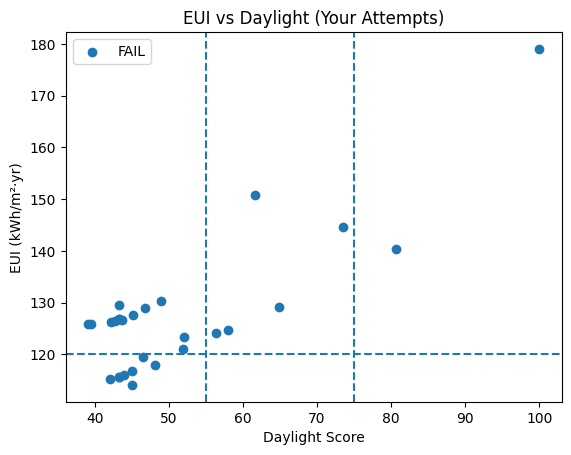

In [ ]:
#@title EUI vs Daylight
if len(attempts) == 0:
    print("No attempts yet.")
else:
    plt.figure()
    for passed in [True, False]:
        subset = attempts[attempts["PASS"] == passed]
        if len(subset) > 0:
            plt.scatter(subset["DaylightScore"], subset["EUI_kWhm2yr"], label=f"{'PASS' if passed else 'FAIL'}")
    plt.axhline(120, linestyle="--")
    plt.axvline(55, linestyle="--")
    plt.axvline(75, linestyle="--")
    plt.xlabel("Daylight Score")
    plt.ylabel("EUI (kWh/m²·yr)")
    plt.title("EUI vs Daylight (Your Attempts)")
    plt.legend()
    plt.show()

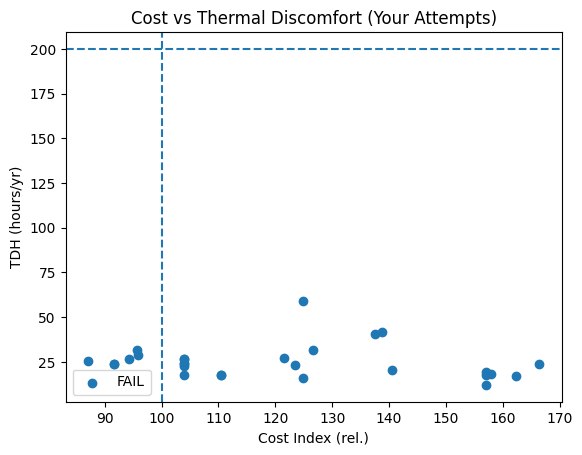

In [ ]:
#@title Cost vs TDH
if len(attempts) == 0:
    print("No attempts yet.")
else:
    plt.figure()
    for passed in [True, False]:
        subset = attempts[attempts["PASS"] == passed]
        if len(subset) > 0:
            plt.scatter(subset["CostIndex"], subset["TDH_hours"], label=f"{'PASS' if passed else 'FAIL'}")
    plt.axvline(100, linestyle="--")
    plt.axhline(200, linestyle="--")
    plt.xlabel("Cost Index (rel.)")
    plt.ylabel("TDH (hours/yr)")
    plt.title("Cost vs Thermal Discomfort (Your Attempts)")
    plt.legend()
    plt.show()

## Strategy Hints (Use After a Few Attempts)
- Start from a **mid-range** WWR (e.g., 0.35–0.45) and tune **shading** to bring **EUI** and **TDH** down while watching **daylight**.
- Increase **insulation** to cut **EUI/TDH** but keep an eye on **cost**.
- Nudge **orientation** away from high-gain directions if TDH is stubborn.
- Try to **hit daylight first**, then “trim” energy/comfort/cost with shading & insulation.

In [ ]:
#@title Local neighborhood probe (optional)
def probe_neighborhood(step=0.03):
    if len(attempts) == 0:
        print("No attempts yet.")
        return pd.DataFrame()

    last_row = attempts.iloc[-1]

    base = dict(
        wwr=float(last_row["WWR"]),
        shading_m=float(last_row["ShadingDepth"]),
        insulation=float(last_row["Insulation"]),
        orientation_deg=float(last_row["Orientation_deg"]),
    )
    deltas = [
        ("wwr", step), ("wwr", -step),
        ("shading_m", step), ("shading_m", -step),
        ("insulation", step), ("insulation", -step),
        ("orientation_deg", 10), ("orientation_deg", -10),
    ]

    rows = []
    for k, d in deltas:
        candidate = base.copy()
        candidate[k] = candidate[k] + d
        EUI, daylight, TDH, Cost = simulate_building(**candidate)
        passed = (EUI <= EUI_TARGET) and (DAYLIGHT_MIN <= daylight <= DAYLIGHT_MAX) and (TDH <= TDH_TARGET) and (Cost <= COST_TARGET)
        rows.append({
            "WWR": round(candidate["wwr"],3),
            "ShadingDepth": round(candidate["shading_m"],3),
            "Insulation": round(candidate["insulation"],3),
            "Orientation_deg": round(candidate["orientation_deg"],1),
            "EUI_kWhm2yr": round(EUI,2),
            "DaylightScore": round(daylight,1),
            "TDH_hours": round(TDH,1),
            "CostIndex": round(Cost,1),
            "PASS": bool(passed)
        })
    df = pd.DataFrame(rows)
    from IPython.display import display
    display(df)
    return df

In [ ]:
# Example usage (uncomment to run after a few attempts):
probe_neighborhood()

,WWR,ShadingDepth,Insulation,Orientation_deg,EUI_kWhm2yr,DaylightScore,TDH_hours,CostIndex,PASS
0,0.48,0.50,0.60,120.0,147.02,77.0,42.5,140.1,False
1,0.42,0.50,0.60,120.0,142.15,70.0,38.0,134.9,False
2,0.45,0.53,0.60,120.0,144.20,73.1,39.5,139.8,False
3,0.45,0.47,0.60,120.0,144.92,74.0,41.0,135.2,False
4,0.45,0.50,0.63,120.0,143.21,73.5,39.0,139.8,False
5,0.45,0.50,0.57,120.0,145.91,73.5,41.5,135.2,False
6,0.45,0.50,0.60,130.0,144.13,72.0,43.1,137.5,False
7,0.45,0.50,0.60,110.0,145.04,74.6,37.1,137.5,False


,WWR,ShadingDepth,Insulation,Orientation_deg,EUI_kWhm2yr,DaylightScore,TDH_hours,CostIndex,PASS
0,0.48,0.50,0.60,120.0,147.02,77.0,42.5,140.1,False
1,0.42,0.50,0.60,120.0,142.15,70.0,38.0,134.9,False
2,0.45,0.53,0.60,120.0,144.20,73.1,39.5,139.8,False
3,0.45,0.47,0.60,120.0,144.92,74.0,41.0,135.2,False
4,0.45,0.50,0.63,120.0,143.21,73.5,39.0,139.8,False
5,0.45,0.50,0.57,120.0,145.91,73.5,41.5,135.2,False
6,0.45,0.50,0.60,130.0,144.13,72.0,43.1,137.5,False
7,0.45,0.50,0.60,110.0,145.04,74.6,37.1,137.5,False


## Reflection
1. How many attempts did it take to pass all targets?
2. Which variable had the **strongest** effect on **daylight**? On **EUI**?
3. Describe one **trade-off** you observed.
4. If you were to automate this, what would be your **search strategy**?

# Random Search

In [ ]:
import random, math, numpy as np

def random_feasible_try(n=200000, seed=42):
    random.seed(seed)
    for _ in range(n):
        wwr = random.uniform(0.10, 0.80)
        shading = random.uniform(0.0, 1.2)
        ins = random.uniform(0.0, 1.0)
        orient = random.uniform(0.0, 180.0)
        EUI, daylight, TDH, Cost = simulate_building(wwr, shading, ins, orient)
        if (EUI <= 120 and 55 <= daylight <= 75 and TDH <= 200 and Cost <= 100):
            return dict(WWR=round(wwr,3), Shading_m=round(shading,3), Insulation=round(ins,3),
                        Orientation_deg=round(orient,1), EUI=round(EUI,2),
                        Daylight=round(daylight,1), TDH=round(TDH,1), Cost=round(Cost,1))
    return None

random_feasible_try()

{'WWR': 0.182,
 'Shading_m': 0.016,
 'Insulation': 0.871,
 'Orientation_deg': 78.8,
 'EUI': 118.3,
 'Daylight': 55.1,
 'TDH': 15.8,
 'Cost': 98.6}

# Grid Search

In [ ]:
#@title Imports & surrogate (EUI version)
import math, numpy as np, pandas as pd
import matplotlib.pyplot as plt

def simulate_building(wwr: float, shading_m: float, insulation: float, orientation_deg: float):
    # Clamp inputs
    wwr = float(np.clip(wwr, 0.10, 0.80))
    shading_m = float(np.clip(shading_m, 0.0, 1.2))
    insulation = float(np.clip(insulation, 0.0, 1.0))
    orientation_deg = float(np.clip(orientation_deg, 0.0, 180.0))

    # Orientation factors
    rad = math.radians(orientation_deg)
    solar_gain_factor = 0.6 + 0.4*abs(math.cos(rad))
    daylight_orient_factor = 0.8 + 0.2*abs(math.sin(rad))

    # Daylight
    daylight_base = 25.0
    daylight_from_glazing = 120.0 * (wwr - 0.10) / (0.80 - 0.10)
    daylight_from_shading = 70.0 * math.exp(-1.8*shading_m)
    daylight = (daylight_base + 0.7*daylight_from_glazing + 0.3*daylight_from_shading) * daylight_orient_factor
    daylight = float(np.clip(daylight, 0.0, 100.0))

    # EUI
    EUI_base = 150.0
    insulation_benefit = 45.0 * insulation
    glazing_penalty = 55.0 * ((wwr - 0.10) / (0.80 - 0.10))
    shading_benefit = 18.0 * (shading_m / 1.2) * solar_gain_factor
    wwr_nonlinear = 25.0 * ((wwr - 0.40)**2)
    EUI = EUI_base - insulation_benefit + glazing_penalty - shading_benefit + wwr_nonlinear

    # Thermal discomfort hours
    TDH = 300.0*solar_gain_factor * (0.6*wwr + 0.05) * (1.1 - 0.7*insulation) * (1.0 - 0.55*(shading_m/1.2))
    TDH = max(TDH, 0.0)

    # Cost
    Cost = 25.0 + 75.0*insulation + 90.0*(shading_m/1.2) + 60.0*((wwr - 0.10)/(0.80 - 0.10))

    return float(EUI), float(daylight), float(TDH), float(Cost)

# Targets
EUI_TARGET = 120.0
DAYLIGHT_MIN, DAYLIGHT_MAX = 55.0, 75.0
TDH_TARGET = 200.0
COST_TARGET = 100.0

Adjust n_wwr, n_shading, etc. to make the grid finer/coarser. Start small to keep it fast.

In [ ]:
#@title Grid definition and evaluation
n_wwr, n_shading, n_insul, n_orient = 16, 10, 16, 13  # total ~33k points (quick)
wwr_grid       = np.linspace(0.10, 0.80, n_wwr)
shading_grid   = np.linspace(0.0,  1.2,  n_shading)
insul_grid     = np.linspace(0.0,  1.0,  n_insul)
orient_grid    = np.linspace(0.0,  180.0, n_orient)

rows = []
for w in wwr_grid:
    for s in shading_grid:
        for ins in insul_grid:
            for o in orient_grid:
                EUI, D, TDH, C = simulate_building(w, s, ins, o)
                rows.append((w, s, ins, o, EUI, D, TDH, C))

grid_df = pd.DataFrame(rows, columns=[
    "WWR","ShadingDepth","Insulation","Orientation_deg",
    "EUI_kWhm2yr","DaylightScore","TDH_hours","CostIndex"
])
grid_df.head()

,WWR,ShadingDepth,Insulation,Orientation_deg,EUI_kWhm2yr,DaylightScore,TDH_hours,CostIndex
0,0.1,0.0,0.0,0.0,152.25,36.800000,36.300000,25.0
1,0.1,0.0,0.0,15.0,152.25,39.181135,35.805243,25.0
2,0.1,0.0,0.0,30.0,152.25,41.400000,34.354689,25.0
3,0.1,0.0,0.0,45.0,152.25,43.305382,32.047190,25.0
4,0.1,0.0,0.0,60.0,152.25,44.767434,29.040000,25.0


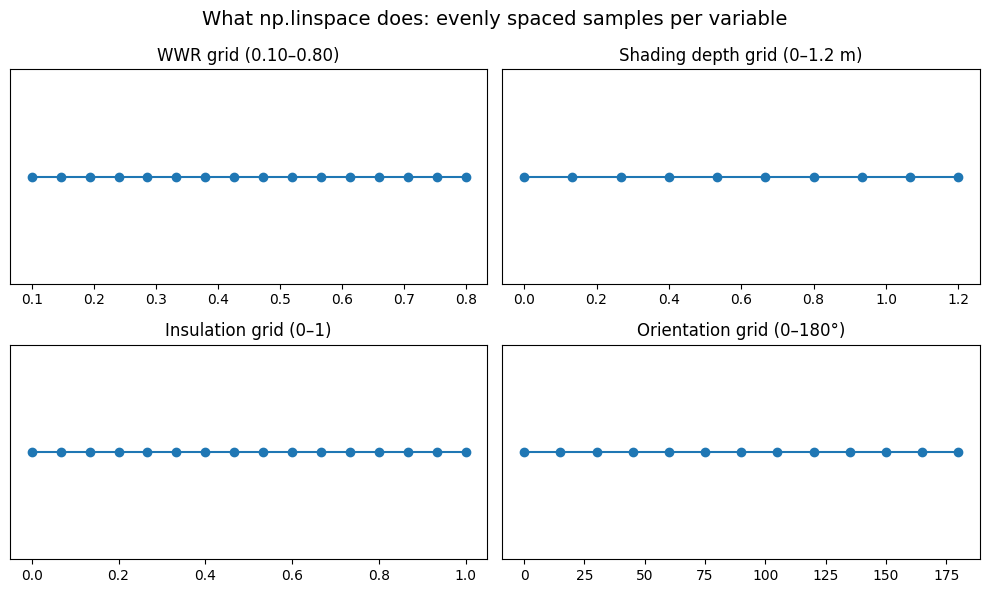

In [ ]:
#@title Visualizing np.linspace for each variable
fig, axs = plt.subplots(2, 2, figsize=(10,6))

axs[0,0].plot(wwr_grid, np.zeros_like(wwr_grid), "o-")
axs[0,0].set_title("WWR grid (0.10–0.80)")
axs[0,0].set_yticks([])

axs[0,1].plot(shading_grid, np.zeros_like(shading_grid), "o-")
axs[0,1].set_title("Shading depth grid (0–1.2 m)")
axs[0,1].set_yticks([])

axs[1,0].plot(insul_grid, np.zeros_like(insul_grid), "o-")
axs[1,0].set_title("Insulation grid (0–1)")
axs[1,0].set_yticks([])

axs[1,1].plot(orient_grid, np.zeros_like(orient_grid), "o-")
axs[1,1].set_title("Orientation grid (0–180°)")
axs[1,1].set_yticks([])

plt.suptitle("What np.linspace does: evenly spaced samples per variable", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
#@title Feasible set and "best" design (min EUI)
feasible = grid_df[
    (grid_df["EUI_kWhm2yr"] <= EUI_TARGET) &
    (grid_df["DaylightScore"] >= DAYLIGHT_MIN) &
    (grid_df["DaylightScore"] <= DAYLIGHT_MAX) &
    (grid_df["TDH_hours"]   <= TDH_TARGET) &
    (grid_df["CostIndex"]   <= COST_TARGET)
].copy()

print(f"Total grid points: {len(grid_df):,}")
print(f"Feasible points:   {len(feasible):,}")

if len(feasible) > 0:
    best = feasible.sort_values("EUI_kWhm2yr", ascending=True).iloc[0]
    print("\nBest feasible (min EUI):")
    display(best)
else:
    print("No feasible points at this grid resolution—try refining the grid or relaxing weights.")

Total grid points: 33,280
Feasible points:   5

Best feasible (min EUI):


,4333
WWR,0.193333
ShadingDepth,0.000000
Insulation,0.866667
Orientation_deg,60.000000
EUI_kWhm2yr,119.401111
DaylightScore,55.667331
TDH_hours,19.654400
CostIndex,98.000000


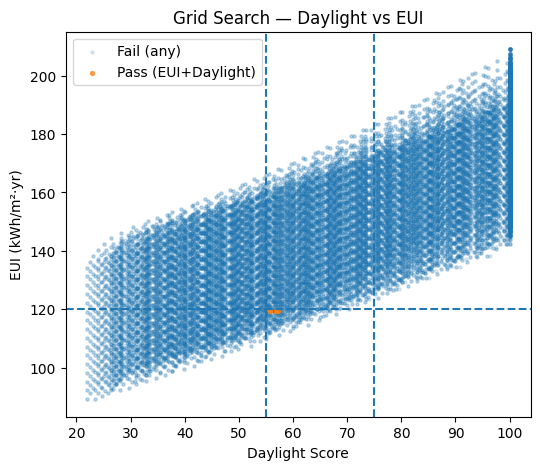

In [ ]:
#@title Daylight vs EUI (pass/fail)
plt.figure(figsize=(6,5))
mask = (
    (grid_df["TDH_hours"] <= TDH_TARGET) &
    (grid_df["CostIndex"] <= COST_TARGET)
)
# "Pass daylight & EUI" within the mask
pass_D_E = mask & (grid_df["DaylightScore"].between(DAYLIGHT_MIN, DAYLIGHT_MAX)) & (grid_df["EUI_kWhm2yr"] <= EUI_TARGET)
fail_D_E = ~pass_D_E

plt.scatter(grid_df.loc[fail_D_E, "DaylightScore"], grid_df.loc[fail_D_E, "EUI_kWhm2yr"], s=5, alpha=0.15, label="Fail (any)")
plt.scatter(grid_df.loc[pass_D_E, "DaylightScore"], grid_df.loc[pass_D_E, "EUI_kWhm2yr"], s=8, alpha=0.7, label="Pass (EUI+Daylight)")

plt.axhline(EUI_TARGET, linestyle="--")
plt.axvline(DAYLIGHT_MIN, linestyle="--")
plt.axvline(DAYLIGHT_MAX, linestyle="--")
plt.xlabel("Daylight Score")
plt.ylabel("EUI (kWh/m²·yr)")
plt.title("Grid Search — Daylight vs EUI")
plt.legend()
plt.show()

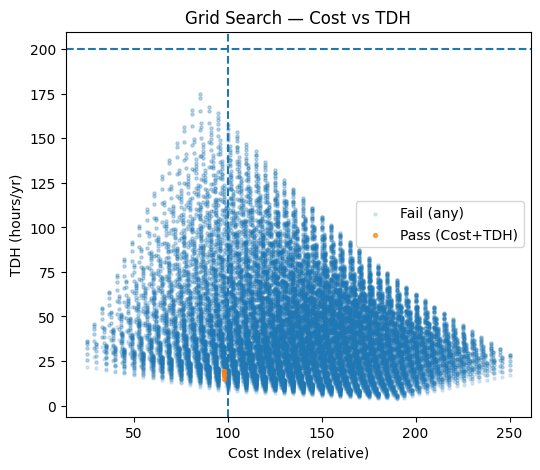

In [ ]:
#@title Cost vs TDH (pass/fail)
plt.figure(figsize=(6,5))
mask2 = (
    (grid_df["DaylightScore"].between(DAYLIGHT_MIN, DAYLIGHT_MAX)) &
    (grid_df["EUI_kWhm2yr"] <= EUI_TARGET)
)
pass_C_T = mask2 & (grid_df["CostIndex"] <= COST_TARGET) & (grid_df["TDH_hours"] <= TDH_TARGET)
fail_C_T = ~pass_C_T

plt.scatter(grid_df.loc[fail_C_T, "CostIndex"], grid_df.loc[fail_C_T, "TDH_hours"], s=5, alpha=0.15, label="Fail (any)")
plt.scatter(grid_df.loc[pass_C_T, "CostIndex"], grid_df.loc[pass_C_T, "TDH_hours"], s=8, alpha=0.7, label="Pass (Cost+TDH)")

plt.axvline(COST_TARGET, linestyle="--")
plt.axhline(TDH_TARGET, linestyle="--")
plt.xlabel("Cost Index (relative)")
plt.ylabel("TDH (hours/yr)")
plt.title("Grid Search — Cost vs TDH")
plt.legend()
plt.show()

Feasible on full grid: 5 / 33,280


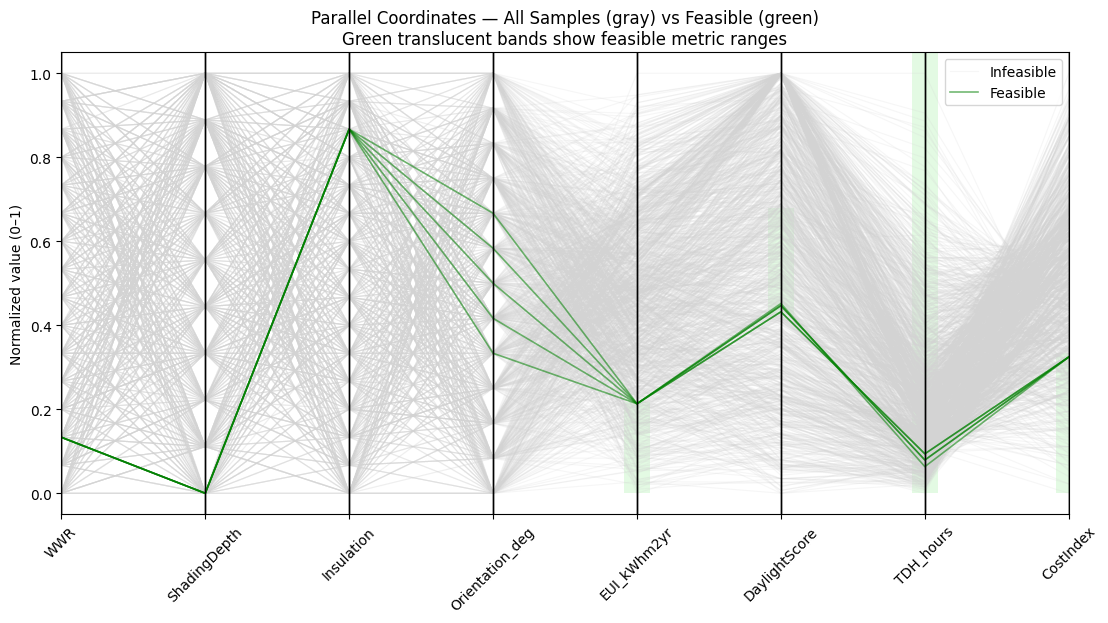

In [ ]:
#@title Parallel Coordinates — All vs Feasible + Feasible Bounds Overlay
from pandas.plotting import parallel_coordinates
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ----- 1) Feasibility on full grid -----
mask_feasible_full = (
    (grid_df["EUI_kWhm2yr"] <= EUI_TARGET) &
    (grid_df["DaylightScore"].between(DAYLIGHT_MIN, DAYLIGHT_MAX)) &
    (grid_df["TDH_hours"] <= TDH_TARGET) &
    (grid_df["CostIndex"] <= COST_TARGET)
)

feasible_df   = grid_df[mask_feasible_full].copy()
infeasible_df = grid_df[~mask_feasible_full].copy()

print(f"Feasible on full grid: {len(feasible_df):,} / {len(grid_df):,}")

if len(feasible_df) == 0:
    print("No feasible designs at this grid resolution. Increase grid density near likely regions or relax constraints.")
else:
    # ----- 2) Sample for readability -----
    FEAS_CAP = 800
    INF_CAP  = 1200
    feas_sample = feasible_df if len(feasible_df) <= FEAS_CAP else feasible_df.sample(FEAS_CAP, random_state=0)
    inf_sample  = infeasible_df.sample(min(INF_CAP, len(infeasible_df)), random_state=0)

    feas_sample = feas_sample.copy(); feas_sample["Class"] = "Feasible"
    inf_sample  = inf_sample.copy();  inf_sample["Class"]  = "Infeasible"

    # ----- 3) Combine & normalize jointly -----
    plot_cols = ["WWR","ShadingDepth","Insulation","Orientation_deg",
                 "EUI_kWhm2yr","DaylightScore","TDH_hours","CostIndex"]
    combined = pd.concat([inf_sample, feas_sample], ignore_index=True)
    normed   = combined.copy()

    # Keep original min/max for each column to map feasible bands correctly
    col_minmax = {c: (combined[c].min(), combined[c].max()) for c in plot_cols}

    for c in plot_cols:
        cmin, cmax = col_minmax[c]
        normed[c] = 0.0 if cmax == cmin else (combined[c] - cmin) / (cmax - cmin)

    # Split for layered plotting
    norm_inf  = normed[normed["Class"] == "Infeasible"]
    norm_feas = normed[normed["Class"] == "Feasible"]

    # ----- 4) Plot lines in two passes -----
    fig = plt.figure(figsize=(13,6))
    ax = plt.gca()

    if len(norm_inf) > 0:
        parallel_coordinates(norm_inf[plot_cols+["Class"]], "Class",
                             color=["lightgray"], alpha=0.20, linewidth=0.8, ax=ax)

    parallel_coordinates(norm_feas[plot_cols+["Class"]], "Class",
                         color=["green"], alpha=0.55, linewidth=1.2, ax=ax)

    # ----- 5) Overlay feasible bounds on metric axes -----
    # Axes (in order) are at x positions 0..len(plot_cols)-1
    x_positions = {name: i for i, name in enumerate(plot_cols)}

    def add_band(axis_name, low_val=None, high_val=None, band_width=0.18, facecolor="lightgreen", alpha=0.25):
        """
        Draw a vertical thin rectangle centered at the axis (x=i) from low->high (in normalized 0..1 space).
        If only high_val is given (<= bound), low defaults to 0. If only low_val is given (>= bound), high defaults to 1.
        Values are in ORIGINAL units; they will be normalized with the same min/max used above.
        """
        x = x_positions[axis_name]
        cmin, cmax = col_minmax[axis_name]
        # handle one-sided bounds
        if low_val is None and high_val is None:
            return
        if low_val is None:
            low_val = cmin
        if high_val is None:
            high_val = cmax
        # normalize
        y0 = 0.0 if cmax == cmin else (low_val - cmin) / (cmax - cmin)
        y1 = 0.0 if cmax == cmin else (high_val - cmin) / (cmax - cmin)
        ylow, yhigh = min(y0, y1), max(y0, y1)
        rect = Rectangle((x - band_width/2, ylow), band_width, yhigh - ylow,
                         facecolor=facecolor, edgecolor=None, alpha=alpha)
        ax.add_patch(rect)

    # Add bands for performance metrics (using target bounds)
    # EUI ≤ EUI_TARGET  → [min, EUI_TARGET]
    add_band("EUI_kWhm2yr", low_val=col_minmax["EUI_kWhm2yr"][0], high_val=EUI_TARGET)

    # Daylight in [DAYLIGHT_MIN, DAYLIGHT_MAX]
    add_band("DaylightScore", low_val=DAYLIGHT_MIN, high_val=DAYLIGHT_MAX)

    # TDH ≤ TDH_TARGET → [min, TDH_TARGET]
    add_band("TDH_hours", low_val=col_minmax["TDH_hours"][0], high_val=TDH_TARGET)

    # Cost ≤ COST_TARGET → [min, COST_TARGET]
    add_band("CostIndex", low_val=col_minmax["CostIndex"][0], high_val=COST_TARGET)

    # Cosmetics
    plt.title("Parallel Coordinates — All Samples (gray) vs Feasible (green)\nGreen translucent bands show feasible metric ranges")
    plt.ylabel("Normalized value (0–1)")
    plt.xticks(rotation=45)
    plt.show()